<a href="https://colab.research.google.com/github/dimlish/StarAlgorithm/blob/main/CosineStar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

In [2]:
def generate_cosine_func(k, outer_max = 2):
    '''
    generates f(x) = a_1 cos (x) + a_2 cos (2x) + ... + a_k cos (kx)
    [a_1 ... a_k] = outer_coeffs
    a_i ~ U[-outer_max, outer_max]
    
    args:
        k - amount of cosine functions in sum
        outer_max - maximum absolute value of outer coefficient
    returns:
        f(x)
    '''

    outer_coeffs = (torch.rand(k) * 2 * outer_max - outer_max)
    inner_coeffs = torch.arange(1, k+1)
    def func(x_vec):
        res = []
        for x in x_vec:
            res.append(outer_coeffs @ torch.cos(inner_coeffs * x))
        return torch.tensor(res, dtype=torch.float32)

    return func;

class FuncDataset(torch.utils.data.Dataset):
    def __init__(self, size, sigma, f, x_len=3.14):
        self.x = (torch.rand(size) * x_len * 2)
        self.y = f(self.x) + torch.randn(size) * sigma

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def getall(self):
      return (self.x, self.y)

In [3]:
class ThinRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(1, 500)
        self.l2 = nn.Linear(500, 500)
        self.l3 = nn.Linear(500, 500)
        self.l4 = nn.Linear(500, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.l4(x)
        return x

In [4]:
class StarRegression(nn.Module):
    def __init__(self, trained_model, ThinClass):
        super().__init__()
        self.trained = trained_model
        for p in self.trained.parameters():
            p.requires_grad = False
        self.training = ThinClass()
        self.l = nn.Linear(2, 1, bias=False)

    def forward(self, x):
        x = self.l(torch.hstack((self.trained(x), self.training(x))))
        return x

In [5]:
class ThickRegression(nn.Module):
    def __init__(self, ThinClass):
        super().__init__()
        self.m1 = ThinClass()
        self.m2 = ThinClass()
        self.l = nn.Linear(2, 1, bias=False)

    def forward(self, x):
        x = self.l(torch.hstack((self.m1(x), self.m2(x))))
        return x

In [13]:
train_size = 500
test_size = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
b_size = 1
sigma = 0.02
k = 3

f = generate_cosine_func(k)
train_set = FuncDataset(train_size, sigma, f)
test_set = FuncDataset(test_size, sigma, f)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=b_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=b_size)

thin = ThinRegression()
thick = ThickRegression(ThinRegression)
thin.to(device)
thick.to(device)
crit = nn.MSELoss()

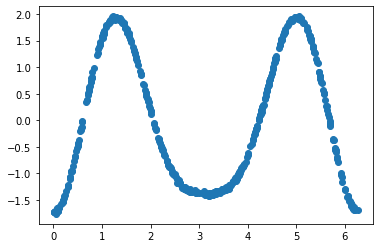

In [14]:
(x, y) = train_set.getall()
plt.scatter(x, y)
plt.show()

In [18]:
def train(model, trainloader, testloader, epoch_num, lr=0.01, tol=1e-5, test_freq=2, name=None):
    '''
        args:
        model - model to be trained
        trainloader - dataloader of training dataset
        testloader - dataloader of testing dataset
        epoch_num - amount of epoches to train
        name - name of model (only for printing)
        tol - tolerance of loss, if difference is < tol, training is stopped
        test_freq - frequency, every test_freq epoches loss on testing dataset is calculated
        
        returns:
          losses - list of avg loss on training dataset per every test_freq epoches
    '''
    
    
    if name is not None:
        print("\n" + '-' * 50)
        print(name + ":")
    losses = []
    optimizer = optim.SGD(model.parameters(), lr)
    for epoch in range(epoch_num):
        for x_train, y_train in trainloader:
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(x_train)
      
            loss = crit(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        if epoch % test_freq == 0:
            mean_val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_test, y_test in testloader:
                    x_test = x_test.to(device)
                    y_test = y_test.to(device)
                    y_pred = model(x_test)
                    loss = crit(y_pred, y_test)
                    mean_val_loss.append(loss.numpy())
            print('Epoch: {epoch}, loss: {loss}'.format(
                    epoch=epoch, loss=np.mean(mean_val_loss)
            ))
            losses.append(np.mean(mean_val_loss))
            if losses[-1] != losses[-1]:
              raise ValueError("NaN loss")
            if len(losses) > 2 and abs(losses[-1] - losses[-2]) < tol:
                while len(losses) != epoch_num // test_freq:
                  losses.append(losses[-1]) # fill the list before finishing training
                break
    return losses

In [19]:
epoch = 100
thin_losses = train(thin, train_loader, test_loader, 100, name="thin")
thick_losses = train(thick, train_loader, test_loader, 100, name="thick")


--------------------------------------------------
thin:
Epoch: 0, loss: 1.2238818407058716
Epoch: 2, loss: 0.8675661683082581
Epoch: 4, loss: 0.8648316264152527
Epoch: 6, loss: 0.8593625426292419
Epoch: 8, loss: 0.8558115363121033
Epoch: 10, loss: 0.8523064255714417
Epoch: 12, loss: 0.850858211517334
Epoch: 14, loss: 0.8500234484672546
Epoch: 16, loss: 0.8493529558181763
Epoch: 18, loss: 0.8484447002410889
Epoch: 20, loss: 0.8479702472686768
Epoch: 22, loss: 0.8471913933753967
Epoch: 24, loss: 0.8466074466705322
Epoch: 26, loss: 0.8463537096977234
Epoch: 28, loss: 0.8459867835044861
Epoch: 30, loss: 0.8459004759788513
Epoch: 32, loss: 0.8456246852874756
Epoch: 34, loss: 0.8454843163490295
Epoch: 36, loss: 0.8454188704490662
Epoch: 38, loss: 0.8452957272529602
Epoch: 40, loss: 0.8451679348945618
Epoch: 42, loss: 0.8451411724090576
Epoch: 44, loss: 0.8450042009353638
Epoch: 46, loss: 0.8449389934539795
Epoch: 48, loss: 0.8449124097824097
Epoch: 50, loss: 0.8448821902275085
Epoch: 52, l

In [20]:
star = StarRegression(thin, ThinRegression)
star_losses = train(star, train_loader, test_loader, 100, name="star")


--------------------------------------------------
star:
Epoch: 0, loss: 0.8347721695899963
Epoch: 2, loss: 0.8126279711723328
Epoch: 4, loss: 0.7952355742454529
Epoch: 6, loss: 0.7667390704154968
Epoch: 8, loss: 0.7610991597175598
Epoch: 10, loss: 0.6559656262397766
Epoch: 12, loss: 0.5542243719100952
Epoch: 14, loss: 0.6524688601493835
Epoch: 16, loss: 0.5018010139465332
Epoch: 18, loss: 0.6359798908233643
Epoch: 20, loss: 0.6394137144088745
Epoch: 22, loss: 0.7965750694274902
Epoch: 24, loss: 0.7331981658935547
Epoch: 26, loss: 0.3475186228752136
Epoch: 28, loss: 0.7596381306648254
Epoch: 30, loss: 0.39740294218063354
Epoch: 32, loss: 0.3666199743747711
Epoch: 34, loss: 0.5386463403701782
Epoch: 36, loss: 0.26326242089271545
Epoch: 38, loss: 0.3952982425689697
Epoch: 40, loss: 0.3546528220176697
Epoch: 42, loss: 0.38185587525367737
Epoch: 44, loss: 0.3824811577796936
Epoch: 46, loss: 0.25096094608306885
Epoch: 48, loss: 0.218655526638031
Epoch: 50, loss: 0.3526991605758667
Epoch: 5

In [11]:
for p in star.l.named_parameters():
  print(p) # weights of neural networks in star

('weight', Parameter containing:
tensor([[nan, nan]], requires_grad=True))


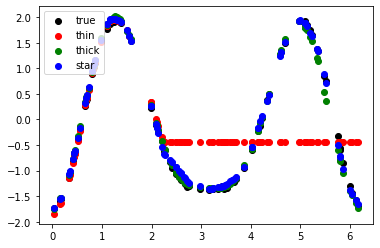

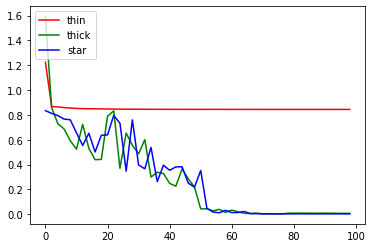

In [21]:
plt.figure(1)

(x, y) = test_set.getall()
x = x.reshape((test_size, 1))
plt.scatter(x, y, c='black', label='true')

y = thin(x)
plt.scatter(x, y.detach().numpy(), c='r', label='thin')

y = thick(x)
plt.scatter(x, y.detach().numpy(), c='g', label='thick')

y = star(x)
plt.scatter(x, y.detach().numpy(), c='b', label='star')


plt.legend(loc='upper left')
plt.show()



indexes = [i for i in range(0, epoch, 2)]

plt.figure(2)
plt.plot(indexes, thin_losses, c='r', label='thin')
plt.plot(indexes, thick_losses, c='g', label='thick')
plt.plot(indexes, star_losses, c='b', label='star')
plt.legend(loc='upper left')
plt.show()


In [ ]:
indexes = [i for i in range(0, epoch, 2)]

plt.plot(indexes, thin_losses, c='r', label='thin')
plt.plot(indexes, thick_losses, c='g', label='thick')
plt.plot(indexes, star_losses, c='b', label='star')
plt.legend(loc='upper left')
plt.show()